In [15]:
import duckdb
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from anytree import RenderTree
from lib.tree_functions import import_tree_from_json
from lib.config import pipeline_name, db_name, tree_json_path
import tempfile
from lib import count_plot
import networkx as nx

base_url = "https://cdl-segg.fra1.cdn.digitaloceanspaces.com/cdl-segg/"

### Download Section Tree

In [16]:
tree_url = base_url + tree_json_path
response = requests.get(tree_url)
response.raise_for_status()
with tempfile.NamedTemporaryFile(delete=False, suffix=".json") as temp_file:
    temp_file.write(response.content)
    path = temp_file.name
    root_node = import_tree_from_json(path)

for pre, fill, node in RenderTree(root_node):
    print(f"{pre}{node.name} ({node.data_id})")

Pimp my School Downloads (36)
├── 1.1. Was ist Schülervertretungsarbeit (38)
├── 1.2. Rechtliche Grundlagen (39)
│   ├── Mecklenburg-Vorpommern (41)
│   ├── Besonderheiten an einzelnen Schulformen (42)
│   │   └── Oberstufenzentren (OSZ) (159)
│   ├── Nordrhein-Westfalen (52)
│   │   └── Erlasse (55)
│   ├── Sachsen-Anhalt (53)
│   ├── Berlin (56)
│   │   ├── Besonderheiten Berufsschulen (57)
│   │   ├── Formales für Gremien (58)
│   │   └── Schülervertretung in Bezirk und Land (59)
│   ├── Hessen (132)
│   └── Brandenburg (153)
├── 1.3. Mögliche Aktionen, Themen und Projekte von A-Z (46)
│   ├── Unterricht verändern (47)
│   ├── Projektideensammlungen zur Inspiration (111)
│   ├── Aktionen und Projekte (Beschreibungen) (51)
│   │   ├── Lesenacht (105)
│   │   ├── Party (106)
│   │   ├── Schulball (107)
│   │   ├── Schülernachhilfe-Pool (108)
│   │   ├── Valentinstag (109)
│   │   ├── Schülerfirma (160)
│   │   └── Veranstaltungen (110)
│   └── Klimaschutz & Nachhaltigkeit (161)
├

### Download Files

In [17]:
posts_url = base_url + "downloads.parquet"
response = requests.get(posts_url)
response.raise_for_status()
df = pl.read_parquet(response.content)
df.head()

data_id,data_category_id,title,category_title,download_link,file_type
i64,i64,str,str,str,str
4165,104,"""Handlungsplan""","""Methoden""","""https://meinsvwissen.de/downlo…","""pdf"""
4216,120,"""Selbstvorstellung Leibniz Gymn…","""Videos und Selbstvorstellungen""","""https://meinsvwissen.de/downlo…","""mp4"""
3969,89,"""Flyer Werde Schülervertreter_…","""2.1.2. Schülersprecher_innen""","""https://meinsvwissen.de/downlo…","""pdf"""
4077,98,"""Sitzungen und Versammlungen vo…","""Planung""","""https://meinsvwissen.de/downlo…","""pdf"""
4255,74,"""Schlaues Buch 2""","""4.2. Wissen dokumentieren und …","""https://meinsvwissen.de/downlo…","""pdf"""


In [18]:
df["file_type"].value_counts().sort("count", descending=True)

file_type,count
str,u32
"""pdf""",400
"""octet-stream""",114
"""png""",36
"""jpeg""",19
"""mp4""",18


### Posts

In [19]:
posts_url = base_url + "posts.parquet"
response = requests.get(posts_url)
response.raise_for_status()
df = pl.read_parquet(response.content)
df.head()

id,date,title,stage,tool_types,topics,download_chapter_dedicated,download_chapters_further,book_chapter,related_posts
i64,date,str,str,list[cat],list[str],i64,list[i64],str,list[i64]
4659,2022-03-15,"""Finanzierung""","""profis""","[""praesentation""]","[""antraege"", ""finanzierung"", ""projektarbeit""]",null,[73],"""https://meinsvwissen.de/wp-con…","[4689, 8395, … 3529]"
5675,2022-05-04,"""Leitfaden: Instagram-Account d…","""fortgeschrittene""","[""infografik""]","[""ideenfindung"", ""oeffentlichkeitsarbeit""]",null,[71],null,"[7700, 4746, … 8395]"
6182,2022-10-03,"""Test: wichtige Kontakte in der…","""fortgeschrittene""","[""selbsttest""]","[""antraege"", ""gremien"", … ""rechte""]",null,[],null,"[6182, 6182, … 8395]"
4801,2022-03-17,"""Amtsantritt von SV-Teams""","""sv-alltag""","[""praesentation"", ""vorlage""]","[""einarbeitung"", ""ideenfindung"", ""sv-team""]",null,[64],"""https://meinsvwissen.de/wp-con…","[5821, 5138]"
5191,2022-03-30,"""Selbsttest: Öffentlichkeitsarb…","""sv-alltag""","[""selbsttest""]","[""oeffentlichkeitsarbeit""]",null,[65],null,"[6540, 7700, … 3087]"


In [20]:
df["stage"].value_counts().sort("count", descending=True)

stage,count
str,u32
"""sv-alltag""",40
"""grundlagen""",35
"""fortgeschrittene""",16
"""profis""",13
null,11


In [21]:
df["stage"].unique().to_list()

['sv-alltag', 'fortgeschrittene', 'profis', 'grundlagen', None]

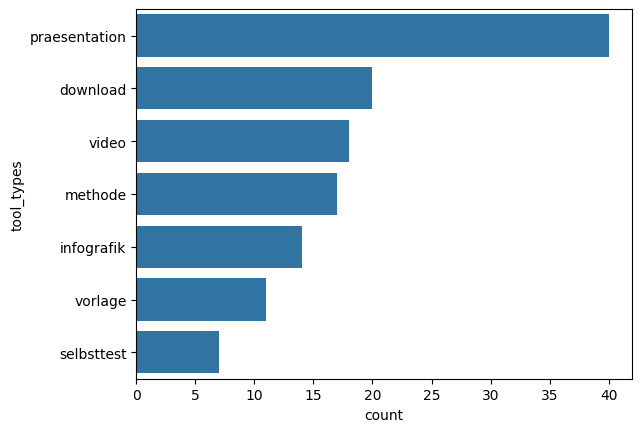

In [22]:
count_plot(df, "tool_types")

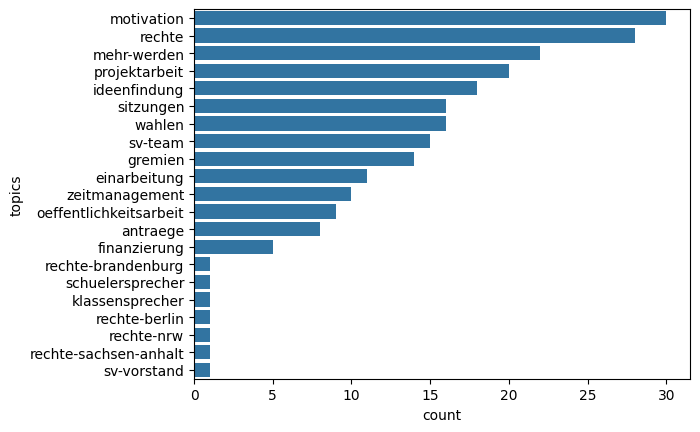

In [23]:
count_plot(df, "topics")

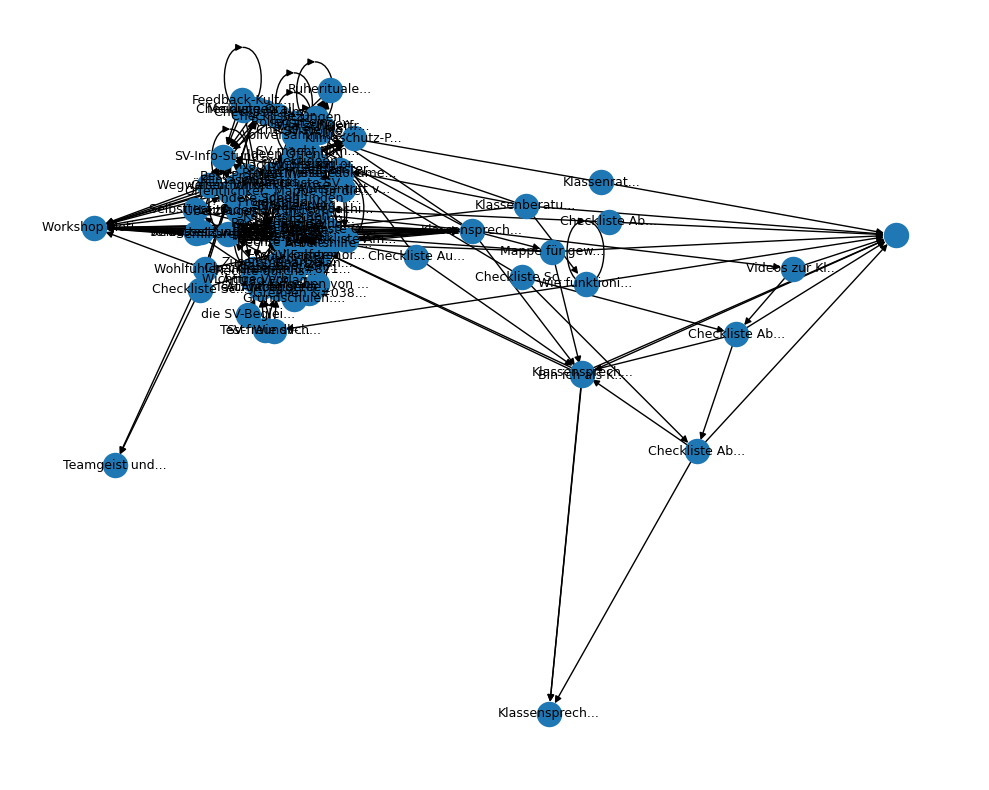

In [24]:
records = df.to_dicts()

G = nx.DiGraph()
for rec in records:
    src = rec["id"]
    G.add_node(src, label=f"{rec["title"][:13]}...")
    for tgt in rec.get("related_posts") or []:
        G.add_edge(src, tgt)

# identify nodes with degree 0 or 1
nodes_to_remove = [n for n, d in G.degree() if d <= 1]
G.remove_nodes_from(nodes_to_remove)

pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(
    G,
    pos,
)
nx.draw_networkx_edges(
    G,
    pos,
)
labels = nx.get_node_attributes(G, "label")
nx.draw_networkx_labels(G, pos, labels, font_size=9, font_family="sans-serif")

plt.axis("off")
plt.tight_layout()
plt.show()

In [25]:
self_loop_nodes = [n for n in G.nodes() if G.has_edge(n, n)]

# 2. Or via self-loop edges
self_loop_nodes = list({u for u, v in nx.selfloop_edges(G)})

print("Node IDs with self-loops:", self_loop_nodes)


Node IDs with self-loops: [4878, 5138, 7700, 7327, 6182, 7081, 4909, 5294, 6198, 6582, 6588, 5821, 8387, 5319, 8395, 6987, 6735, 4816, 4968, 6008]


### Sections

In [26]:
posts_url = base_url + "sections.parquet"
response = requests.get(posts_url)
response.raise_for_status()
df = pl.read_parquet(response.content)
df.head()

post_id,title,text,type,external_link
i64,str,str,cat,str
5675,null,"""Ihr könnt Social Media, wie z.…","""plain_text""",null
5675,"""Instagram-Account erstellen""",null,"""h5p""",null
6182,null,""" Jede Schülervertretung brauch…","""quiz""",null
5191,null,""" Wie viel ist an eurer Schule …","""quiz""",null
4801,null,"""Beim Start eines neuen SV-Team…","""plain_text""",null


In [27]:
df["type"].value_counts().sort("count", descending=True)

type,count
cat,u32
"""plain_text""",121
"""accordion_section_text""",112
"""flipcard""",60
"""accordion_section_image""",41
"""image""",31
"""h5p""",24
"""accordion_section_youtube""",23
"""accordion_section_prezi""",17
"""prezi""",16


### Glossary Terms

In [28]:
posts_url = base_url + "glossary_terms.parquet"
response = requests.get(posts_url)
response.raise_for_status()
df = pl.read_parquet(response.content)
df.head()

term,definition,DE,DE_BW,DE_BY,DE_BE,DE_BB,DE_HB,DE_HH,DE_HE,DE_MV,DE_NI,DE_NW,DE_RP,DE_SL,DE_SN,DE_ST,DE_SH,DE_TH
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""Antrag""","""Ein Antrag ist ein Vorschlag, …",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Aufgabenprofil""","""Ihr schreibt transparent und k…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Auftaktveranstaltung / SV-Tag""","""Start in die SV-Arbeit zu Begi…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Bezirks-/ Kreis & Landesschüle…",null,"""BSK (Bundesschülerkonferenz – …",null,null,"""BSA und LSA (Bezirksschüler- u…","""KSR und LSR (Kreisschüler- und…",null,null,null,"""KSR und LSR (Kreisschüler- und…",null,"""BSV und LSV (Bezirksschüler- u…",null,null,null,"""KSR und LSR (Kreisschüler- und…",null,"""Kreisschülersprecher:innen und…"
"""BSK""","""Bundesschülerkonferenz. Sie be…","""Bundesschülerkonferenz. Sie be…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
